# Sentiment Analysis of FOMC Statements

Analyse statement by Loughran and McDonald dictionary

In [2]:
%config InlineBackend.figure_format='retina'
import logging
from ekorpkit import eKonf

logging.basicConfig(level=logging.WARNING)
print(eKonf.__version__)

0.1.32+6.ged4b0a1.dirty


In [3]:
start_year = 2000

## Load FRED Data

In [4]:
cfg = eKonf.compose(config_group="io/fetcher=quandl")
cfg.series_name = "DFEDTAR"
cfg.series_id = ["DFEDTAR", "DFEDTARU"]
cfg.force_download = True
quandl = eKonf.instantiate(cfg)

fedrates = quandl.data.copy()
fedrates

,DFEDTAR,series_id
date,,
1982-09-27,10.25,DFEDTAR
1982-09-28,10.25,DFEDTAR
1982-09-29,10.25,DFEDTAR
1982-09-30,10.25,DFEDTAR
1982-10-01,10.00,DFEDTAR
...,...,...
2022-06-06,1.00,DFEDTARU
2022-06-07,1.00,DFEDTARU
2022-06-08,1.00,DFEDTARU


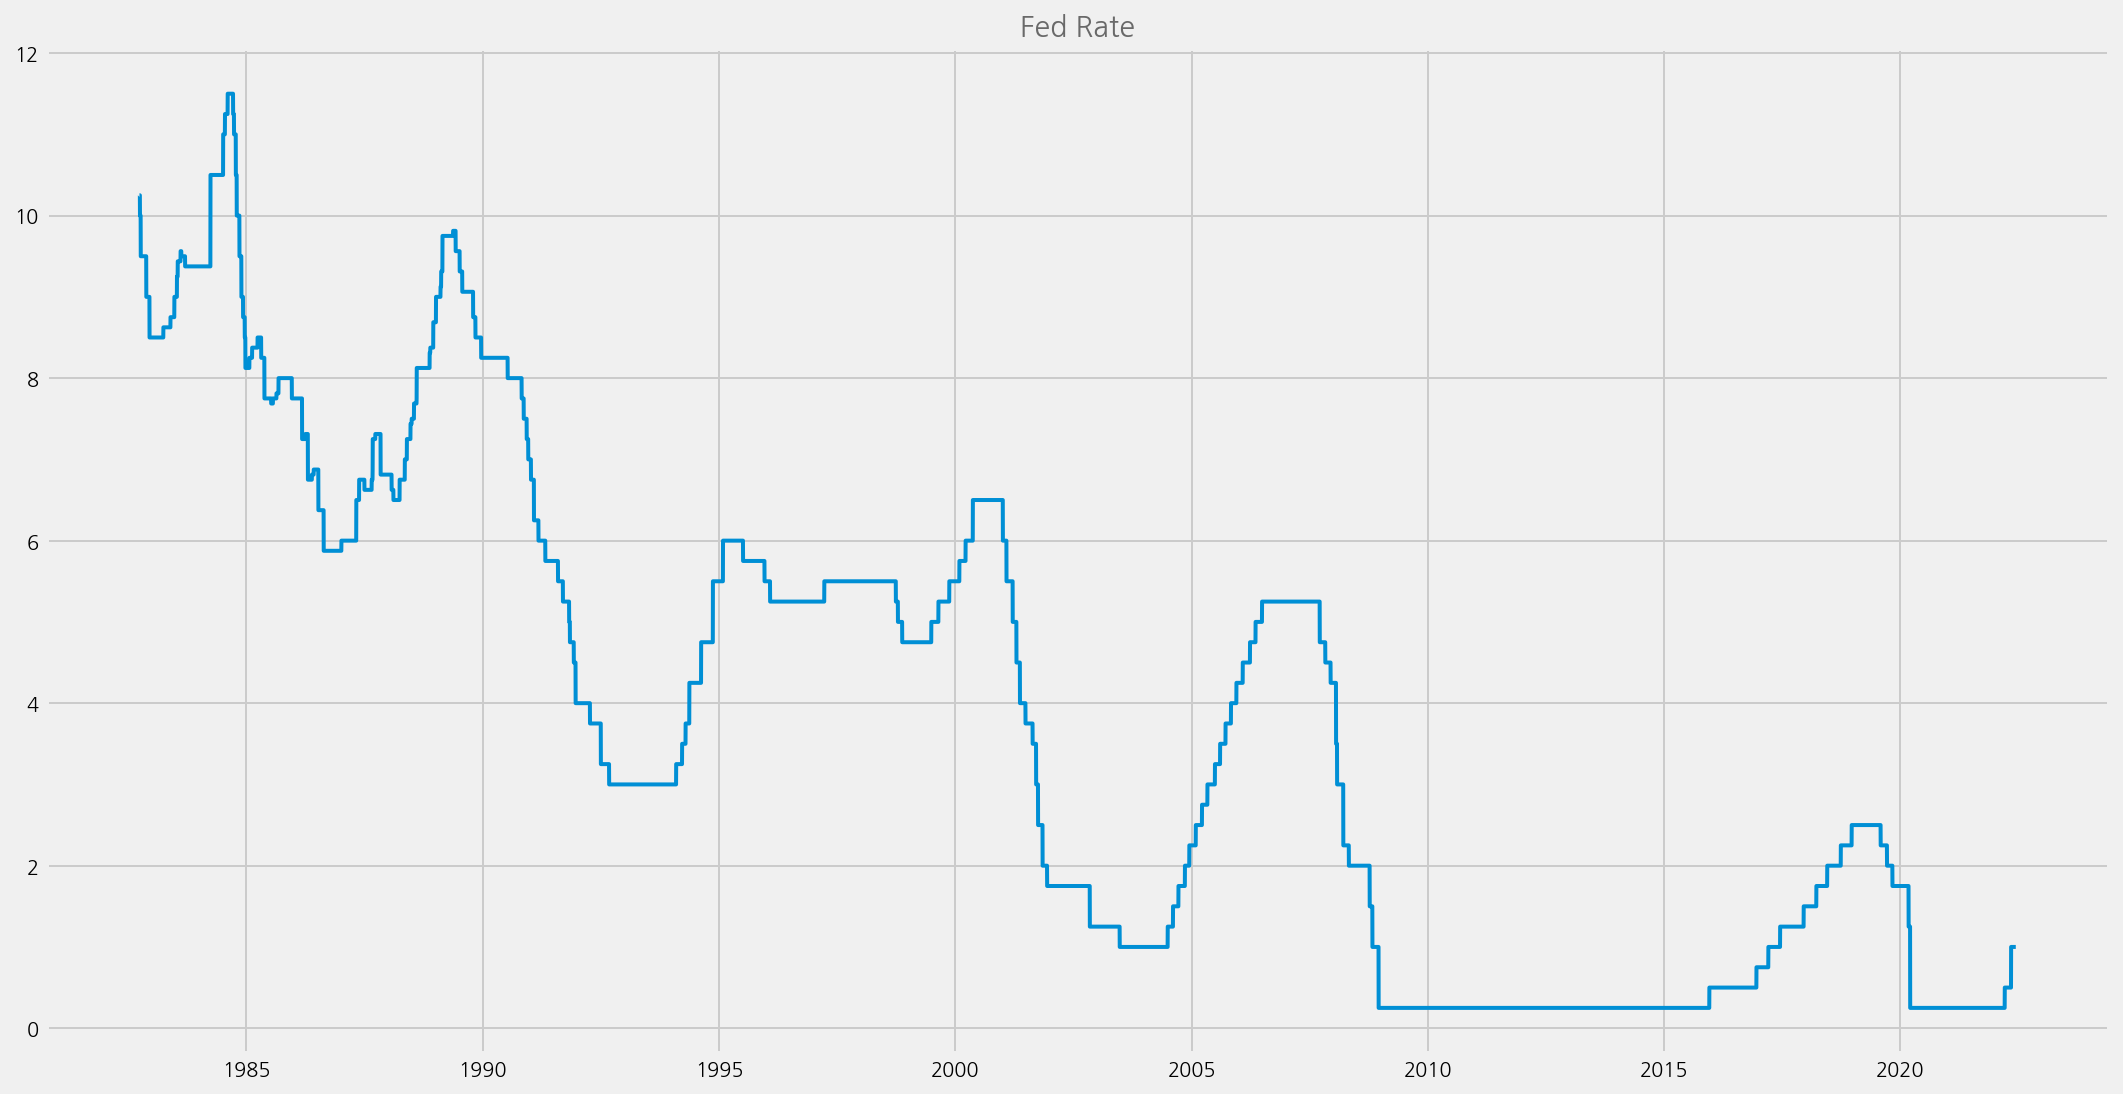

In [5]:
cfg = eKonf.compose(config_group='visualize/plot=lineplot')
cfg.plot.y = 'DFEDTAR'
cfg.figure.figsize = (15, 8)
cfg.ax.title = 'Fed Rate'
eKonf.instantiate(cfg, data=fedrates)

## Load FOMC Corpus

In [6]:
cfg = eKonf.compose("corpus")
cfg.name = "fomc"
cfg.path.cache.uri = (
    "https://github.com/entelecheia/ekorpkit-book/raw/main/data/fomc.zip"
)
cfg.data_dir = cfg.path.cached_path
cfg.auto.merge = True
fomc = eKonf.instantiate(cfg)
print(fomc)

Corpus : fomc


In [7]:
print(fomc.data.content_type.unique())
fomc.data.head()

['fomc_minutes' 'fomc_statement' 'fomc_speech' 'fomc_beigebook'
 'fomc_testimony' 'fomc_press_conf' 'fomc_meeting_script']


,id,text,timestamp,content_type,date,speaker,title
0,0,A meeting of the Federal Open Market Committee...,1993-02-03,fomc_minutes,1993-02-03,Alan Greenspan,FOMC Meeting Minutes
1,1,A meeting of the Federal Open Market Committee...,1993-03-23,fomc_minutes,1993-03-23,Alan Greenspan,FOMC Meeting Minutes
2,2,A meeting of the Federal Open Market Committee...,1993-05-18,fomc_minutes,1993-05-18,Alan Greenspan,FOMC Meeting Minutes
3,3,A meeting of the Federal Open Market Committee...,1993-07-07,fomc_minutes,1993-07-07,Alan Greenspan,FOMC Meeting Minutes
4,4,A meeting of the Federal Open Market Committee...,1993-08-17,fomc_minutes,1993-08-17,Alan Greenspan,FOMC Meeting Minutes


In [8]:
fomc_statements = fomc.data[fomc.data.content_type == 'fomc_statement']
fomc_statements = fomc_statements[fomc_statements.timestamp.dt.year >= start_year]
fomc_statements.set_index('timestamp', inplace=True)
fomc_statements.head()

,id,text,content_type,date,speaker,title
timestamp,,,,,,
2000-02-02,250,For immediate release The Federal Open Market ...,fomc_statement,2000-02-02,Alan Greenspan,FOMC Statement
2000-03-21,251,For immediate release The Federal Open Market ...,fomc_statement,2000-03-21,Alan Greenspan,FOMC Statement
2000-05-16,252,For immediate release The Federal Open Market ...,fomc_statement,2000-05-16,Alan Greenspan,FOMC Statement
2000-06-28,253,For immediate release The Federal Open Market ...,fomc_statement,2000-06-28,Alan Greenspan,FOMC Statement
2000-08-22,254,For immediate release The Federal Open Market ...,fomc_statement,2000-08-22,Alan Greenspan,FOMC Statement


## Predict setniments with the LM sentiment analyser

In [8]:
model_cfg = eKonf.compose('model/sentiment=lm')

cfg = eKonf.compose('pipeline/predict')
cfg.name = 'fomc_sentiments'
cfg.model = model_cfg
cfg.output_dir = "./data/predict"
cfg.output_file = f'{cfg.name}-lm.parquet'
cfg.num_workers = 100
fomc_sentiments = eKonf.pipe(cfg, fomc_statements)
fomc_sentiments.head()

Predicting [text]: 100%|██████████| 91/91 [00:27<00:00,  3.32it/s]


,id,text,content_type,date,speaker,title,positive,negative,num_tokens,polarity,polarity2,subjectivity,polarity_label,uncertainty
timestamp,,,,,,,,,,,,,,
2000-02-02,250,For immediate release The Federal Open Market ...,fomc_statement,2000-02-02,Alan Greenspan,FOMC Statement,0.005004,0.017515,1199,-0.555556,-0.012510,0.022519,negative,0.019183
2000-03-21,251,For immediate release The Federal Open Market ...,fomc_statement,2000-03-21,Alan Greenspan,FOMC Statement,0.004847,0.016963,1238,-0.555556,-0.012116,0.021809,negative,0.018578
2000-05-16,252,For immediate release The Federal Open Market ...,fomc_statement,2000-05-16,Alan Greenspan,FOMC Statement,0.013962,0.022688,1146,-0.238095,-0.008726,0.036649,negative,0.020942
2000-06-28,253,For immediate release The Federal Open Market ...,fomc_statement,2000-06-28,Alan Greenspan,FOMC Statement,0.007042,0.007042,994,0.000000,0.000000,0.014085,neutral,0.049296
2000-08-22,254,For immediate release The Federal Open Market ...,fomc_statement,2000-08-22,Alan Greenspan,FOMC Statement,0.007078,0.013145,989,-0.300000,-0.006067,0.020222,negative,0.033367


In [9]:
cfg = eKonf.compose('pipeline/predict')
cfg.name = 'fomc_sentiments'
cfg.output_dir = "./data/predict"
cfg.output_file = f'{cfg.name}-lm.parquet'

fomc_sentiments = eKonf.load_data(cfg.output_file, cfg.output_dir)
fomc_sentiments.head()

,id,text,content_type,date,speaker,title,positive,negative,num_tokens,polarity,polarity2,subjectivity,polarity_label,uncertainty
timestamp,,,,,,,,,,,,,,
2000-02-02,250,For immediate release The Federal Open Market ...,fomc_statement,2000-02-02,Alan Greenspan,FOMC Statement,0.005004,0.017515,1199,-0.555556,-0.012510,0.022519,negative,0.019183
2000-03-21,251,For immediate release The Federal Open Market ...,fomc_statement,2000-03-21,Alan Greenspan,FOMC Statement,0.004847,0.016963,1238,-0.555556,-0.012116,0.021809,negative,0.018578
2000-05-16,252,For immediate release The Federal Open Market ...,fomc_statement,2000-05-16,Alan Greenspan,FOMC Statement,0.013962,0.022688,1146,-0.238095,-0.008726,0.036649,negative,0.020942
2000-06-28,253,For immediate release The Federal Open Market ...,fomc_statement,2000-06-28,Alan Greenspan,FOMC Statement,0.007042,0.007042,994,0.000000,0.000000,0.014085,neutral,0.049296
2000-08-22,254,For immediate release The Federal Open Market ...,fomc_statement,2000-08-22,Alan Greenspan,FOMC Statement,0.007078,0.013145,989,-0.300000,-0.006067,0.020222,negative,0.033367


## Plot the sentiment scores

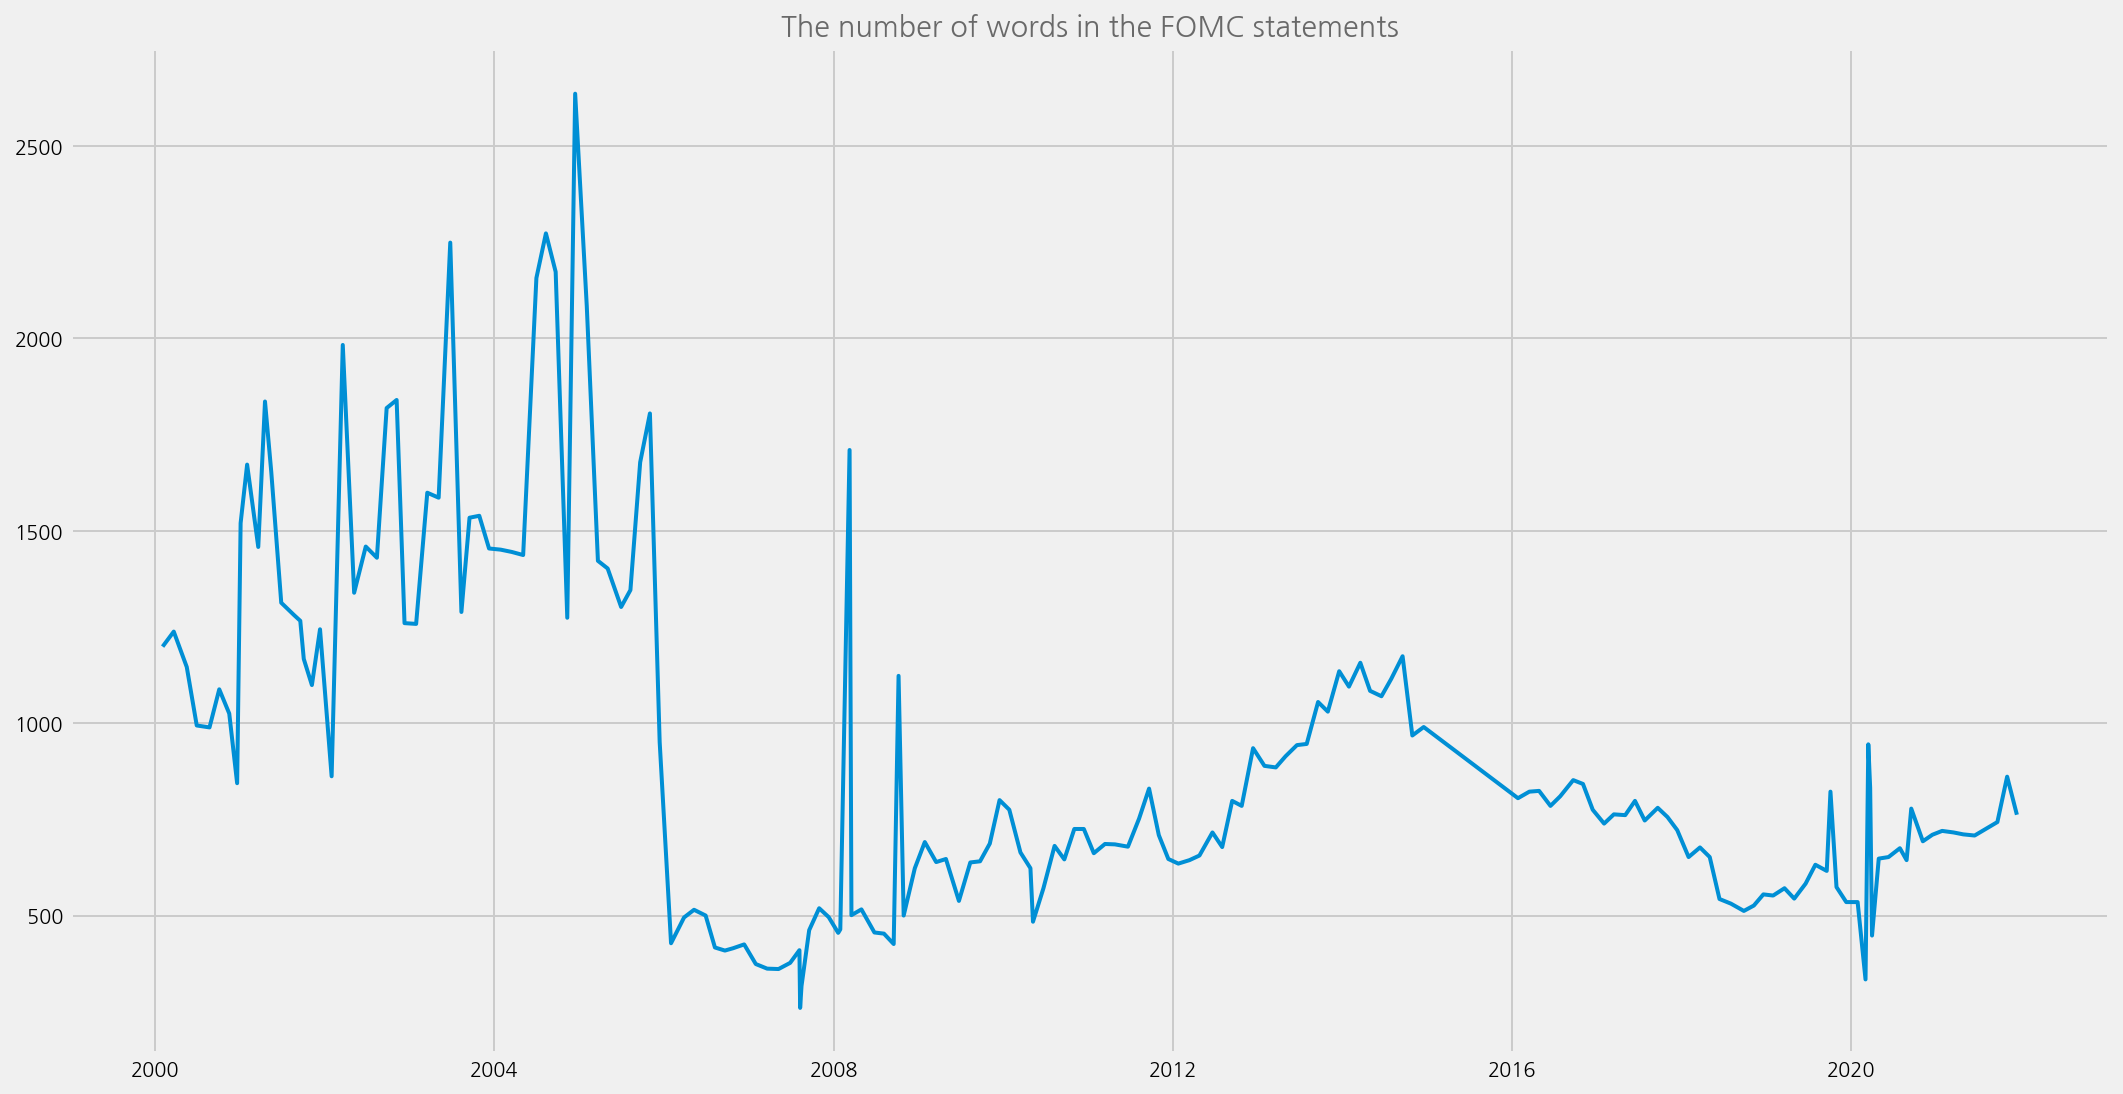

In [10]:
cfg = eKonf.compose('visualize/plot=lineplot')
cfg.plot.y = 'num_tokens'
cfg.figure.figsize = (15, 8)
cfg.ax.title = 'The number of words in the FOMC statements'
cfg.ax.legend = None
eKonf.instantiate(cfg, data=fomc_sentiments)

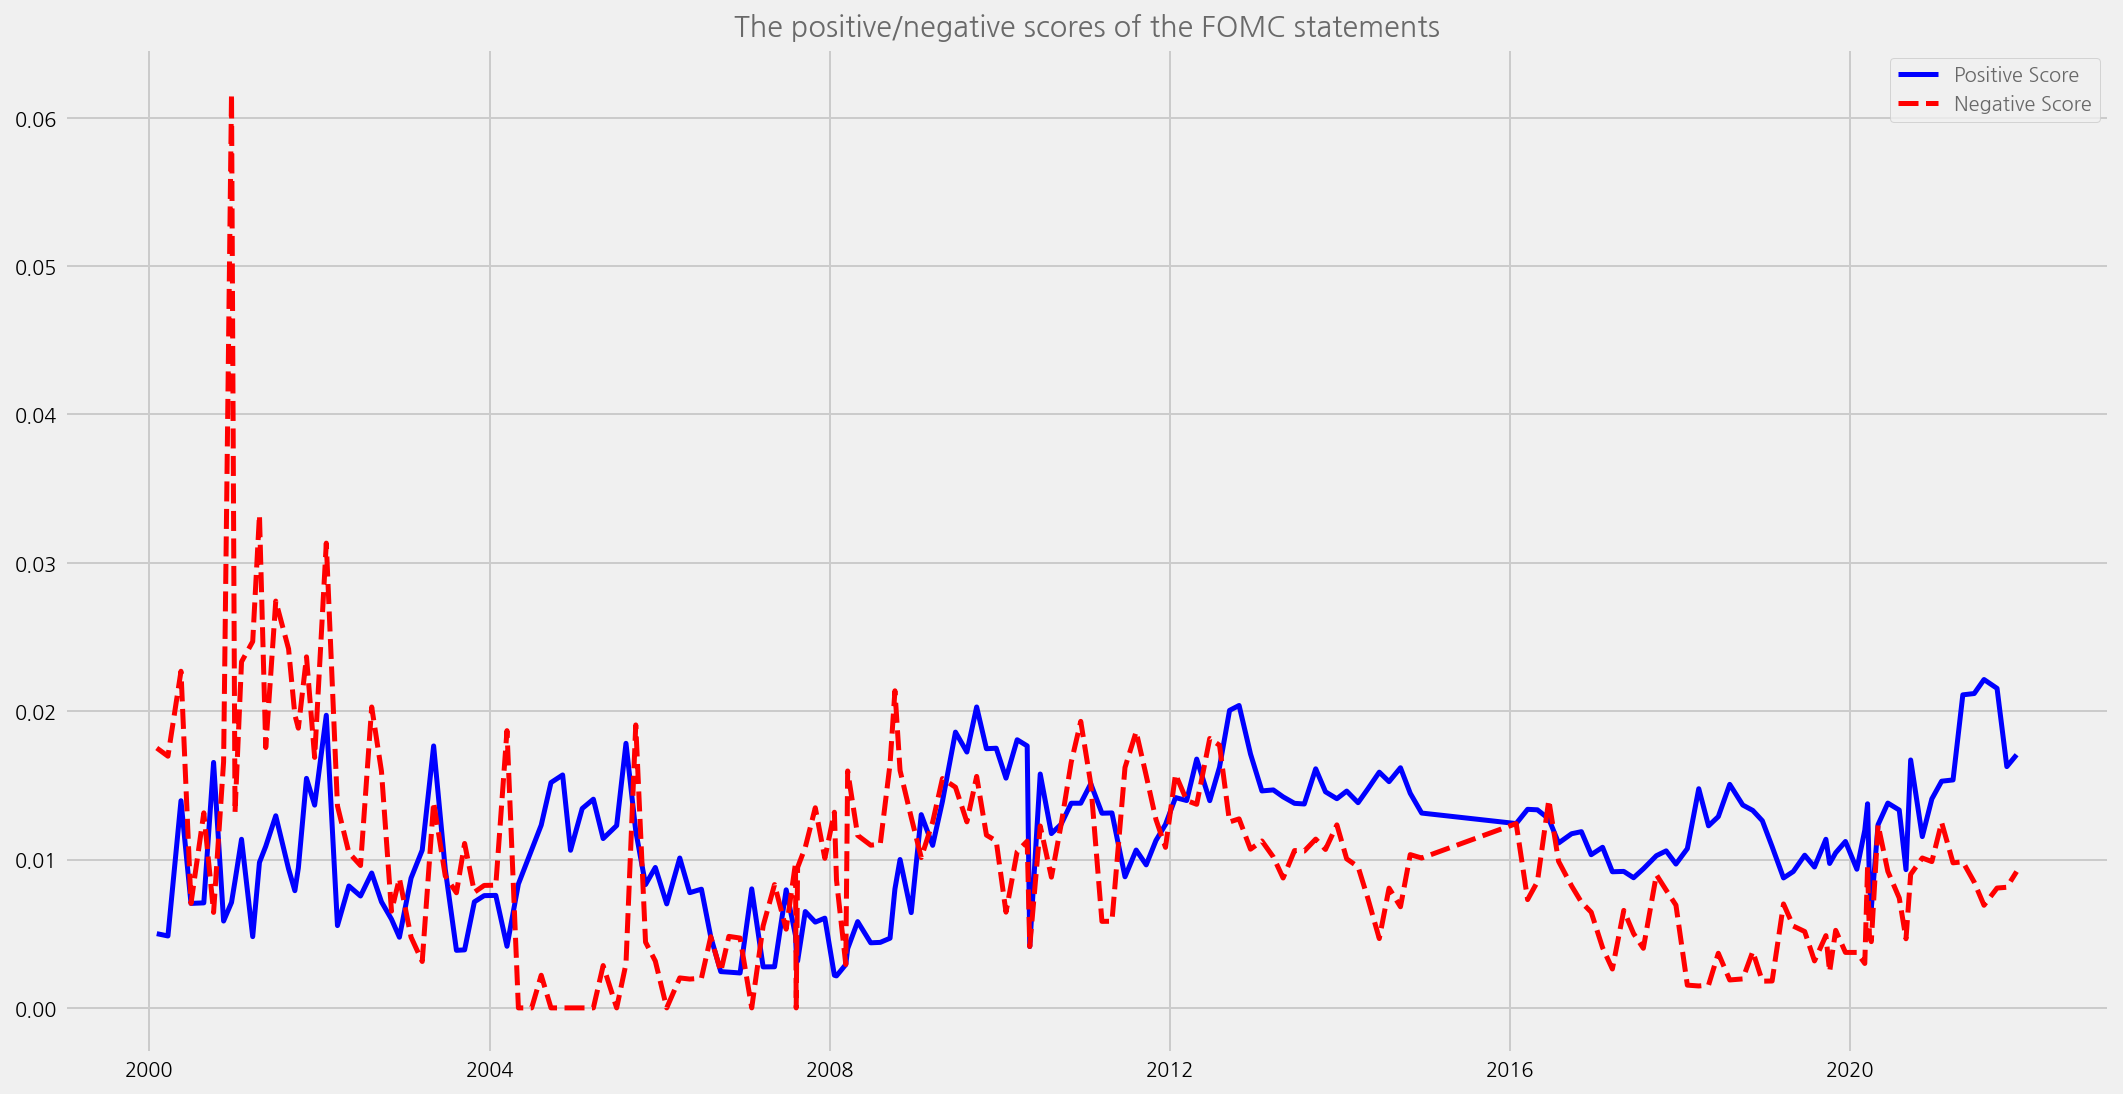

In [11]:
cfg = eKonf.compose("visualize/plot=lineplot")
cfg.plot.y = ["positive", "negative"]
cfg.plot.palette = ["b", "r"]
cfg.plot.linewidth = 2.5
cfg.figure.figsize = (15, 8)
cfg.ax.title = "The positive/negative scores of the FOMC statements"
cfg.ax.legend.labels = ["Positive Score", "Negative Score"]
# eKonf.print(cfg)
eKonf.instantiate(cfg, data=fomc_sentiments)

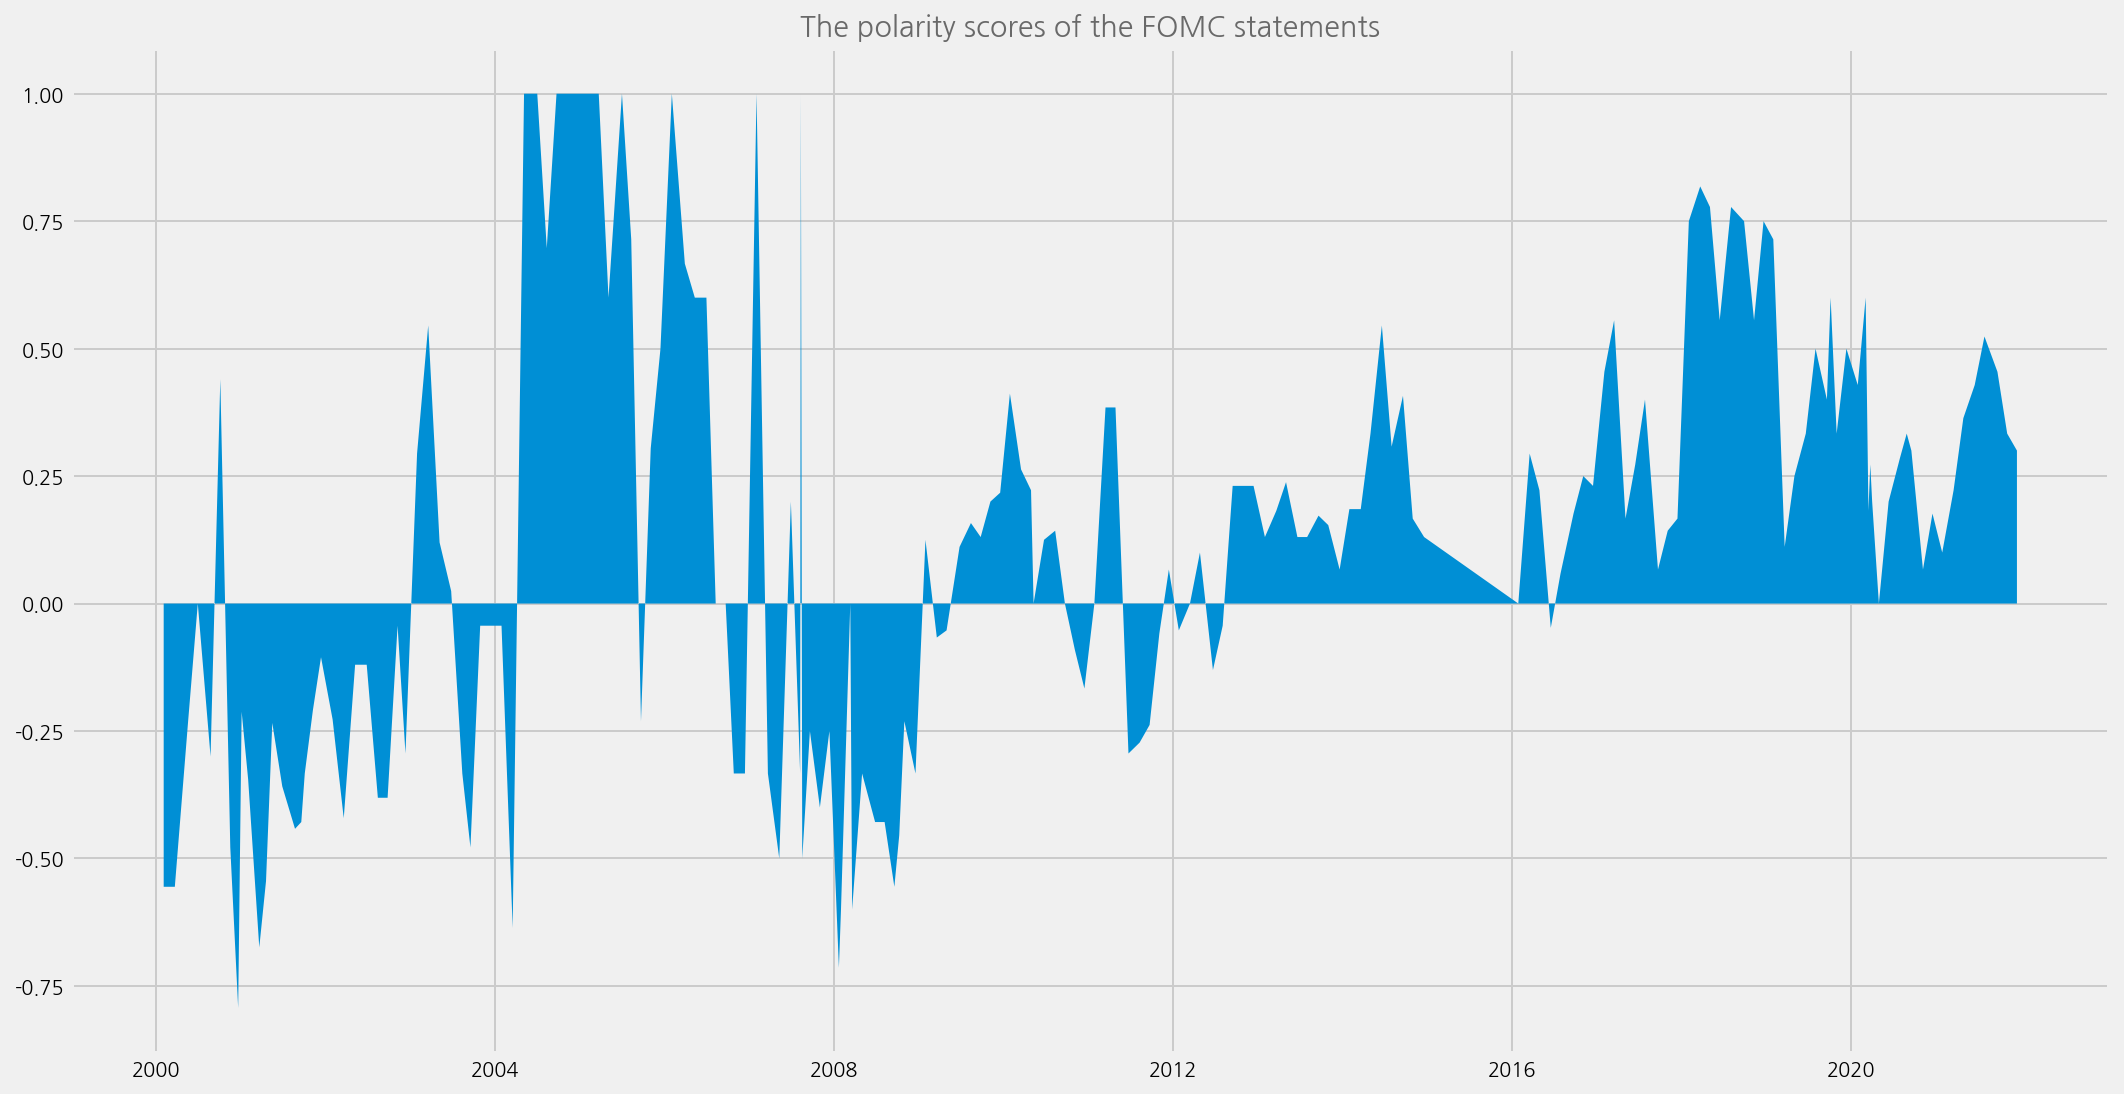

In [12]:
cfg = eKonf.compose('visualize/plot=stackplot')
cfg.plot.y = 'polarity' 
cfg.figure.figsize = (15, 8)
cfg.ax.title = 'The polarity scores of the FOMC statements'
cfg.ax.xtickmajorformatterfunc = "mdates.DateFormatter('%Y')"
eKonf.instantiate(cfg, data=fomc_sentiments)


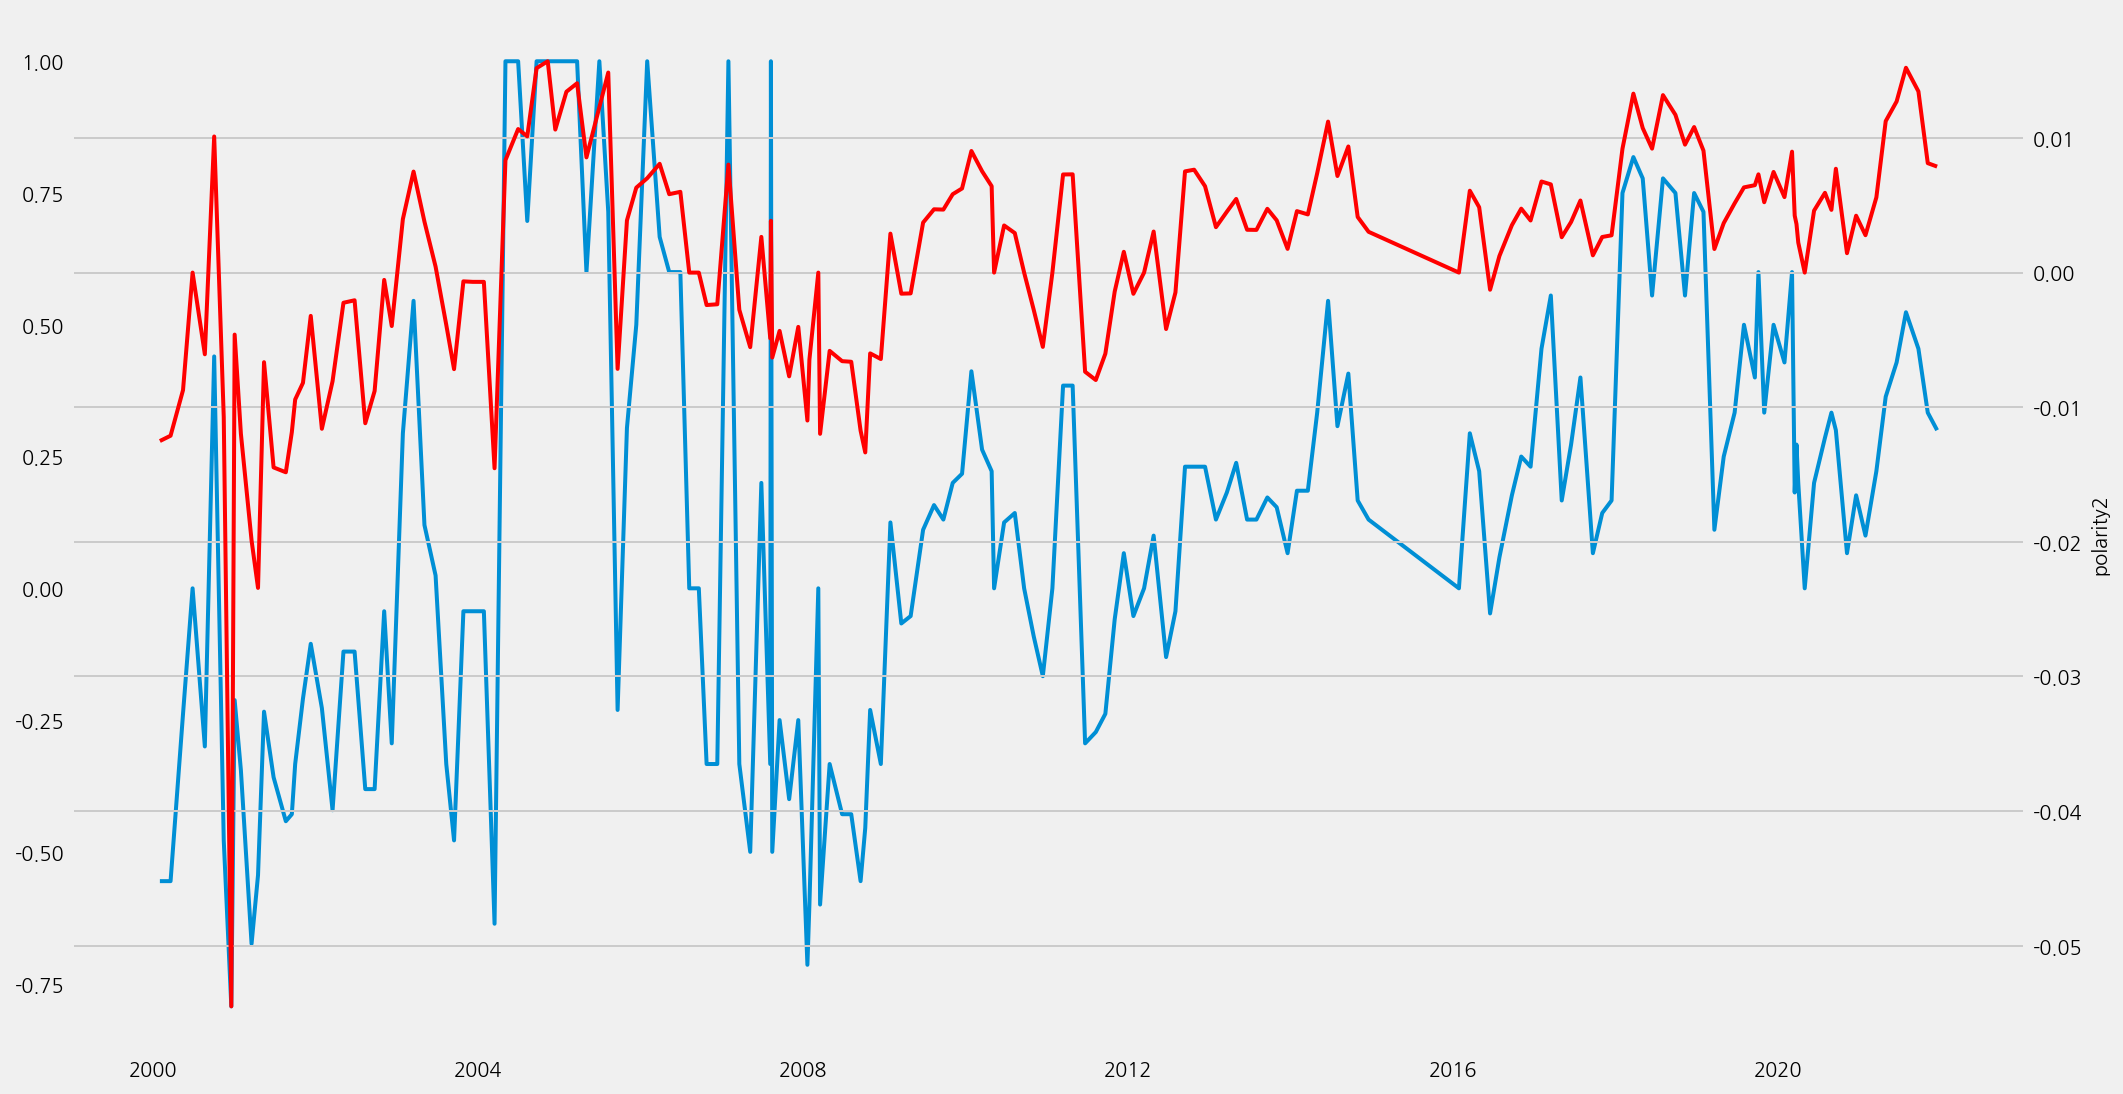

In [15]:
cfg = eKonf.compose('visualize/plot=lineplot')
plot2 = cfg.plot.copy()
cfg.plot.y = 'polarity' 
plot2.y = 'polarity2'
plot2._parms_ = dict(color = "r")
plot2.secondary_y = True
cfg.plots.append(plot2)
cfg.figure.figsize = (15, 8)
ax2 = cfg.ax.copy()
ax2.grid = False
cfg.axes.append(ax2)
eKonf.instantiate(cfg, data=fomc_sentiments)


### Merge with fed rate data

In [13]:
fomc_sentiments = fomc_sentiments.merge(fedrates, left_index=True, right_index=True)
fomc_sentiments.index.name = 'timestamp'
fomc_sentiments.head()

,id,text,content_type,date,speaker,title,positive,negative,num_tokens,polarity,subjectivity,polarity_label,uncertainty,DFEDTAR,series_id
timestamp,,,,,,,,,,,,,,,
2000-02-02,250,For immediate release The Federal Open Market ...,fomc_statement,2000-02-02,Alan Greenspan,FOMC Statement,0.005004,0.017515,1199,-0.012510,0.022519,neutral,0.019183,5.75,DFEDTAR
2000-03-21,251,For immediate release The Federal Open Market ...,fomc_statement,2000-03-21,Alan Greenspan,FOMC Statement,0.004847,0.016963,1238,-0.012116,0.021809,neutral,0.018578,6.00,DFEDTAR
2000-05-16,252,For immediate release The Federal Open Market ...,fomc_statement,2000-05-16,Alan Greenspan,FOMC Statement,0.013962,0.022688,1146,-0.008726,0.036649,neutral,0.020942,6.50,DFEDTAR
2000-06-28,253,For immediate release The Federal Open Market ...,fomc_statement,2000-06-28,Alan Greenspan,FOMC Statement,0.007042,0.007042,994,0.000000,0.014085,neutral,0.049296,6.50,DFEDTAR
2000-08-22,254,For immediate release The Federal Open Market ...,fomc_statement,2000-08-22,Alan Greenspan,FOMC Statement,0.007078,0.013145,989,-0.006067,0.020222,neutral,0.033367,6.50,DFEDTAR


### Plot the results and compare to the economical uncertainty / systemic risk periods

In [14]:
cfg = eKonf.compose("io/fetcher/fomc")
cfg.output_dir = "../data/fomc"
fomc = eKonf.instantiate(cfg)

In [15]:
recessions = fomc.recessions.to_dict(orient="records")

span_args = eKonf.compose("visualize/plot/ax/axvspan")
annot_args = eKonf.compose("visualize/plot/ax/annotation")
span_args.color = "crimson"
span_args.alpha = 0.4

spans = []
annotations = []
for span in recessions:
    annotation = span["name"]
    start = span["from_date"]
    end = span["to_date"]
    span = span_args.copy()
    span.xmin, span.xmax = eKonf.to_dateparm(start), eKonf.to_dateparm(end)

    x = start + (end - start) / 2
    y = -0.75
    annot = annot_args.copy()
    annot.text, annot.x, annot.y = annotation, eKonf.to_dateparm(x), y
    spans.append(span)
    annotations.append(annot)


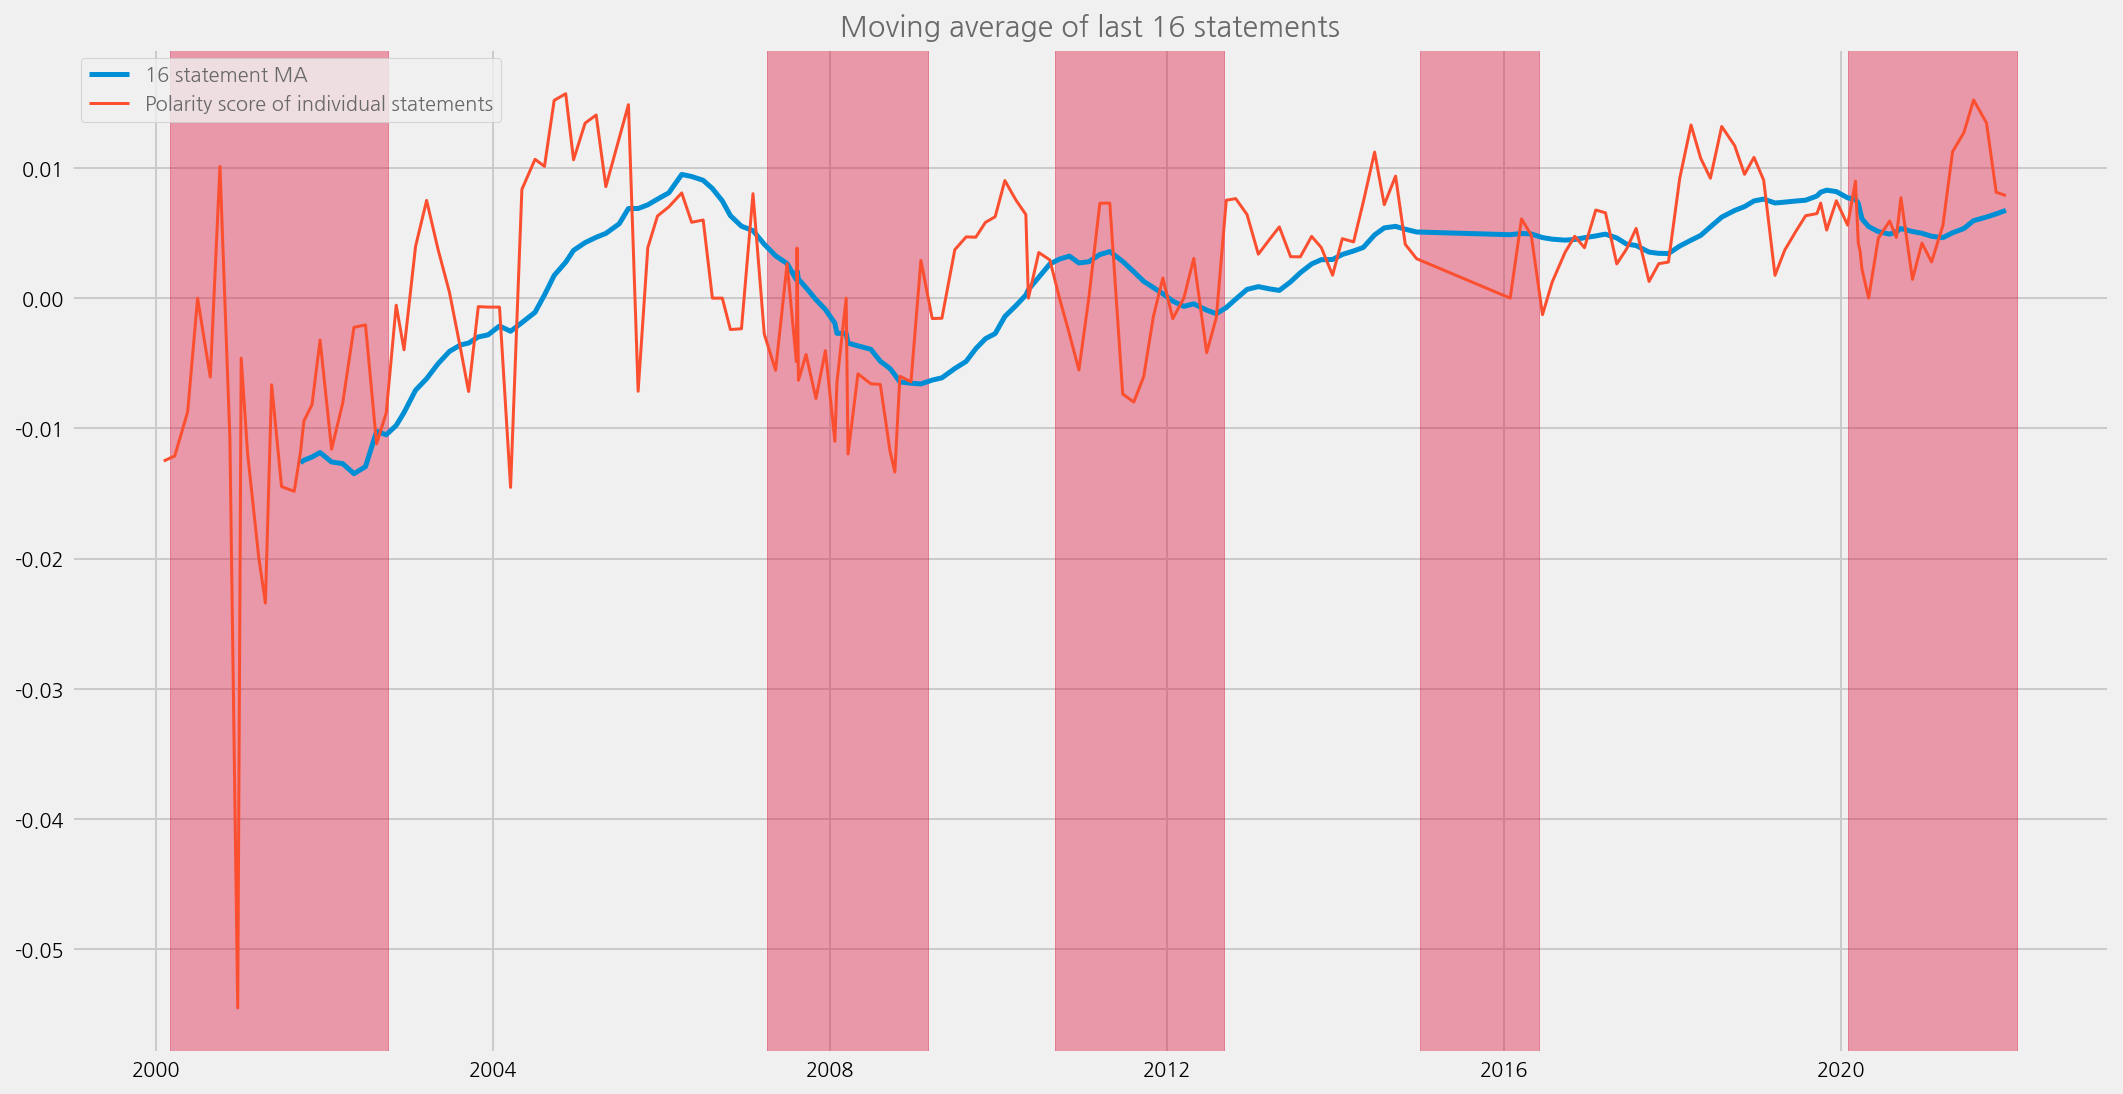

In [16]:
window = 16
fomc_sentiments["polarity_ma"] = fomc_sentiments.polarity.rolling(window).mean()

cfg = eKonf.compose("visualize/plot=lineplot")
cfg.figure.figsize = (15, 8)
cfg.plot.x = "timestamp"
cfg.plots.append(cfg.plot.copy())
cfg.plots[0].y = "polarity_ma"
cfg.plots[0].linewidth = 2.5
cfg.plots[0].palette = "r"
cfg.plots[1].y = "polarity"
cfg.plots[1].linewidth = 1.5
cfg.plots[1].palette = "g"
cfg.ax.title = f"Moving average of last {window} statements"
cfg.ax.legend.labels = [
    f"{window} statement MA",
    "Polarity score of individual statements",
]
cfg.ax.axvspans = spans
cfg.ax.annotations = annotations
eKonf.instantiate(cfg, data=fomc_sentiments)

In [17]:
from datetime import datetime

chair = fomc.chairpersons
chair = chair[chair.to_date.dt.year >= start_year]
annot_args = eKonf.compose("visualize/plot/ax/annotation")

spans = []
annotations = []
for row in chair.iterrows():
    row_num = row[0]
    start = row[1]["from_date"]
    if start.year < 2000:
        start = datetime(2000, 1, 1)
    end = row[1]["to_date"]
    annotation = row[1]["last_name"]
    color = "crimson" if row_num % 2 == 0 else "darkblue"
    alpha = 0.4 if row_num % 2 == 0 else 0.0
    span = {
        "xmin": eKonf.to_dateparm(start),
        "xmax": eKonf.to_dateparm(end),
        "alpha": alpha,
        "color": color,
    }

    x = start + (end - start) / 2
    y = -0.75
    annot = annot_args.copy()
    annot.text, annot.x, annot.y = annotation, eKonf.to_dateparm(x), y

    spans.append(span)
    annotations.append(annot)


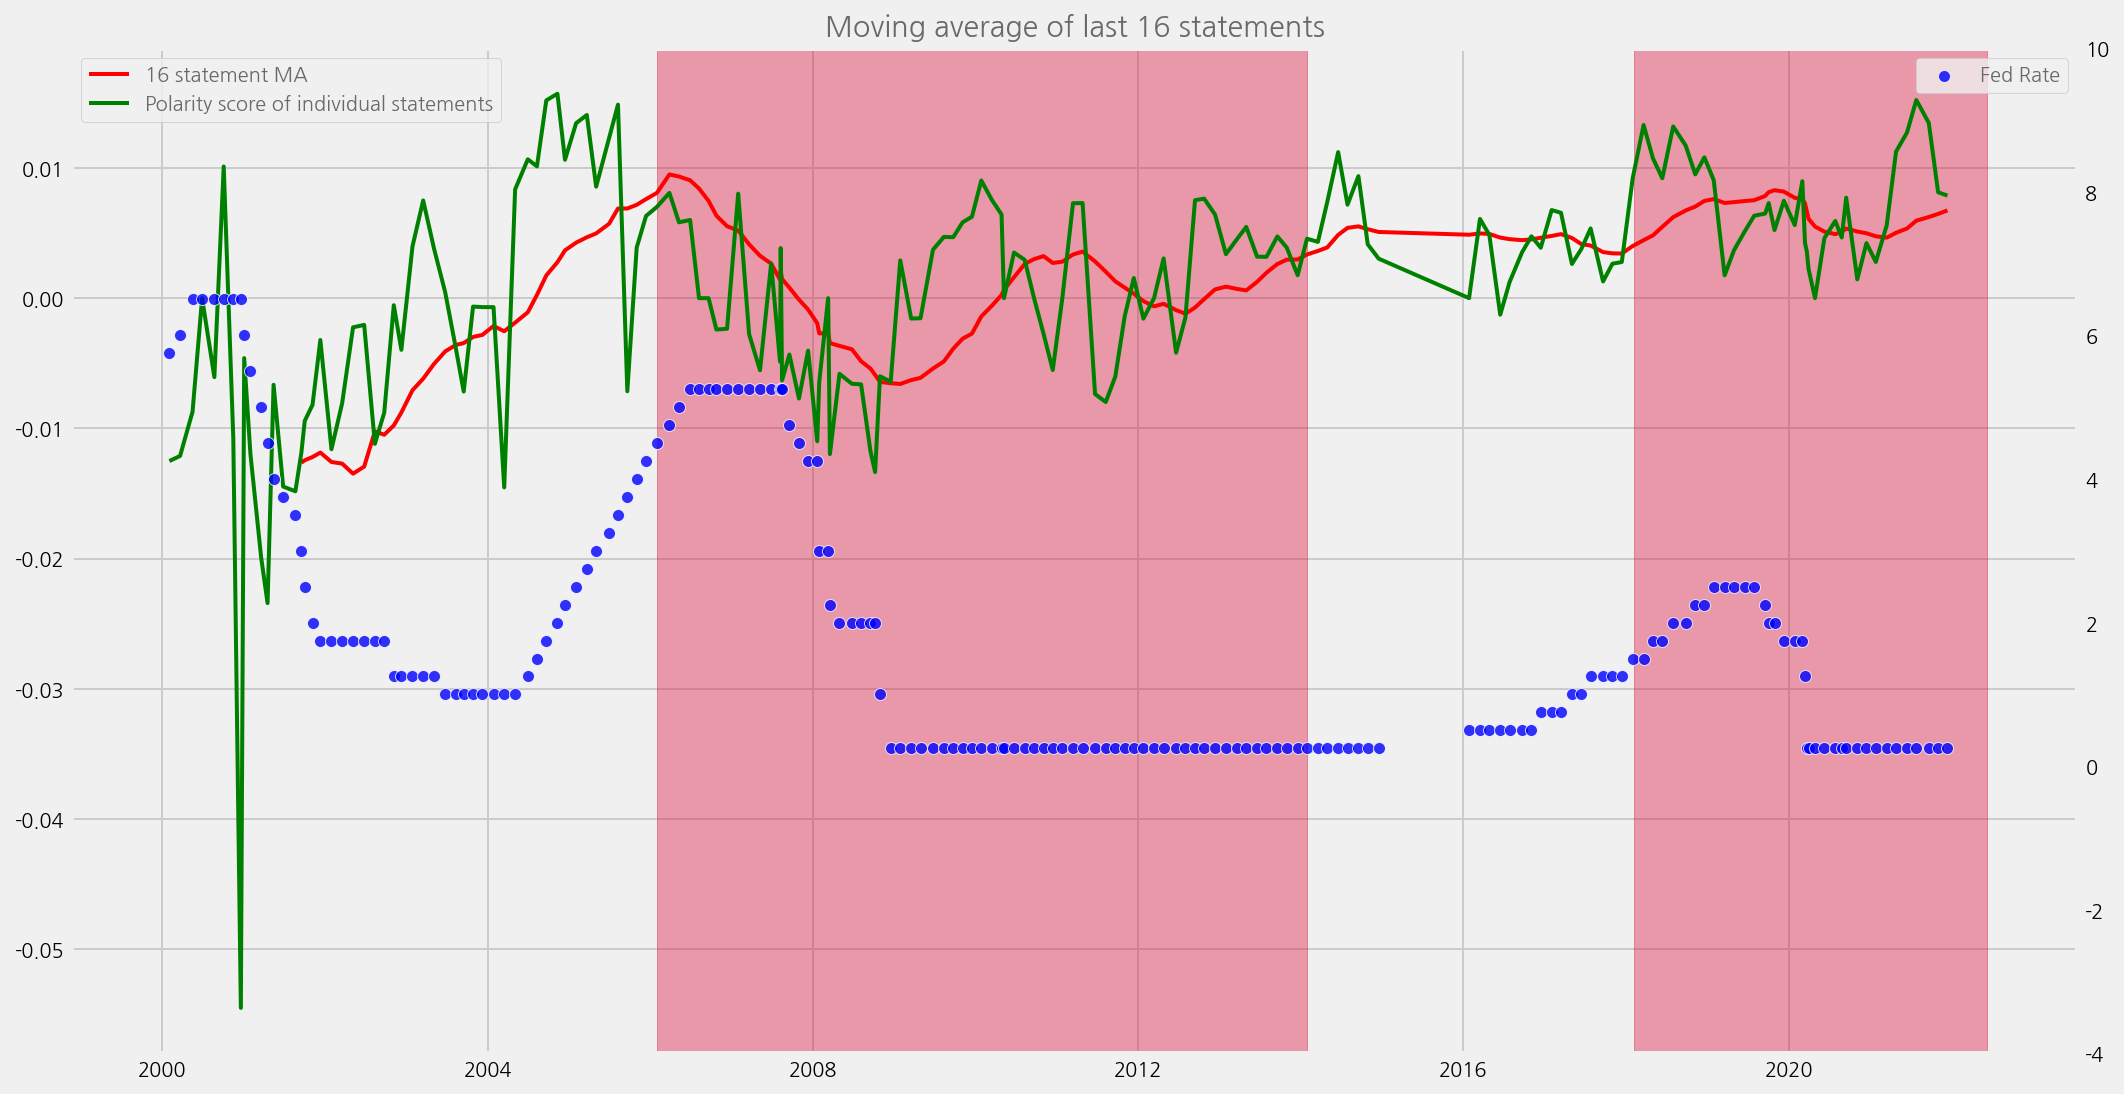

In [18]:
cfg = eKonf.compose("visualize/plot=lineplot")
cfg.plot.x = "timestamp"
ax2 = cfg.ax.copy()

cfg.figure.figsize = (15, 8)
cfg.plots.append(cfg.plot.copy())
cfg.plots[0].y = "polarity_ma"
cfg.plots[0]._parms_ = dict(linewidth=2.5, color="red")
cfg.plots[1].y = "polarity"
cfg.plots[1]._parms_ = dict(linewidth=1.5, color="green")
cfg.ax.title = f"Moving average of last {window} statements"
cfg.ax.legend = dict(
    labels=[
        f"{window} statement MA",
        "Polarity score of individual statements",
    ],
    loc=2,
)
scatter_cfg = eKonf.compose("visualize/plot/scatter")
scatter_cfg.y = "DFEDTAR"
scatter_cfg.secondary_y = True
scatter_cfg._parms_ = dict(color="blue", alpha=0.8)
cfg.plots.append(scatter_cfg)

ax2.grid = False
ax2.secondary_y = True
ax2.ylim = "(-4, 10)"
ax2.legend = dict(
    labels=["Fed Rate"],
    loc=1,
)
cfg.axes.append(ax2)
cfg.ax.axvspans = spans
cfg.ax.annotations = annotations

eKonf.instantiate(cfg, data=fomc_sentiments)
